# DTW Vowel Recognition (MFCC-39) — Notebook Bundle
    
This notebook packages your Dynamic Time Warping (DTW) vowel recognizer using 39‑dimensional MFCCs.
Each class is placed in its own cell (as requested), and additional cells handle configuration, data loading,
evaluation (closed/open set), and visualization.

> **Tip:** Run cells top-to-bottom. If you're on a fresh environment, uncomment the install cell.


In [1]:
# If needed, install deps (uncomment as necessary)
%pip install numpy scipy matplotlib librosa python_speech_features fastdtw


Note: you may need to restart the kernel to use updated packages.


In [11]:
# Imports & globals
import os, re, json, math, itertools, random
from typing import List, Tuple, Dict, Any, Optional
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

try:
    import librosa
    import librosa.display
except Exception as e:
    print("librosa not available yet:", e)

try:
    from python_speech_features import mfcc, delta, logfbank
except Exception as e:
    print("python_speech_features not available yet:", e)

# Reproducibility
random.seed(42)
np.random.seed(42)

# Default vowels dictionary
VOWELS = ["a", "i", "u", "e", "o"]

# Data folders (adjust these to your layout)
TEMPLATES_DIR = "templates_us"
TEST_DIR = "templates_other"
SR = 16000  # expected sample rate; your loader can resample to this


## Class: `VowelRecognitionDTW`

In [12]:
import numpy as np
import librosa
from python_speech_features import mfcc, delta
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import os
from collections import defaultdict
from scipy.signal import medfilt

class VowelRecognitionDTW:
    def __init__(self, sample_rate=16000, use_vad=True, normalize=True):
        """
        Sistem pengenalan vokal menggunakan DTW dan MFCC 39 dimensi
        
        Parameters:
        - sample_rate: sampling rate audio (default 16000 Hz)
        - use_vad: gunakan Voice Activity Detection untuk membuang silence
        - normalize: normalisasi fitur MFCC
        """
        self.sample_rate = sample_rate
        self.use_vad = use_vad
        self.normalize = normalize
        self.templates = {}  # {vowel: {person_id: [list of mfcc_features]}}
        self.vowels = ['a', 'i', 'u', 'e', 'o']
        
    def voice_activity_detection(self, audio, top_db=20):
        """
        Deteksi bagian audio yang mengandung suara (bukan silence)
        Membuang bagian awal dan akhir yang hening
        """
        # Deteksi non-silent intervals
        intervals = librosa.effects.split(audio, top_db=top_db)
        
        if len(intervals) == 0:
            return audio
        
        # Ambil dari awal suara pertama sampai akhir suara terakhir
        start = intervals[0][0]
        end = intervals[-1][1]
        
        return audio[start:end]
    
    def extract_mfcc_39(self, audio_path):
        """
        Ekstraksi fitur MFCC 39 dimensi dengan preprocessing yang lebih baik
        """
        # Load audio file
        audio, sr = librosa.load(audio_path, sr=self.sample_rate)
        
        # Pre-emphasis filter (meningkatkan frekuensi tinggi)
        audio = librosa.effects.preemphasis(audio)
        
        # Voice Activity Detection - buang silence
        if self.use_vad:
            audio = self.voice_activity_detection(audio, top_db=20)
        
        # Normalisasi amplitudo
        audio = audio / (np.max(np.abs(audio)) + 1e-6)
        
        # Ekstraksi 13 MFCC koefisien dengan parameter yang lebih baik
        mfcc_features = mfcc(
            audio, 
            samplerate=sr, 
            numcep=13,
            nfilt=26, 
            nfft=512,
            winstep=0.01,
            winlen=0.025,
            preemph=0,  
            ceplifter=22,
            appendEnergy=True
        )
        
        # Median filtering untuk mengurangi noise
        for i in range(mfcc_features.shape[1]):
            mfcc_features[:, i] = medfilt(mfcc_features[:, i], kernel_size=3)
        
        # Hitung delta (turunan pertama)
        delta_features = delta(mfcc_features, 2)
        
        # Hitung delta-delta (turunan kedua)
        delta2_features = delta(delta_features, 2)
        
        # Gabungkan menjadi 39 dimensi
        features_39 = np.hstack([mfcc_features, delta_features, delta2_features])
        
        # Normalisasi per fitur (Cepstral Mean and Variance Normalization)
        if self.normalize:
            features_39 = (features_39 - np.mean(features_39, axis=0)) / (np.std(features_39, axis=0) + 1e-6)
        
        return features_39
    
    def dtw_distance(self, template, test):
        """
        Menghitung jarak DTW dengan normalisasi path length
        """
        distance, path = fastdtw(template, test, dist=euclidean)
        
        # Normalisasi berdasarkan panjang path untuk fairness
        normalized_distance = distance / len(path)
        
        return normalized_distance
    
    def add_template(self, vowel, person_id, audio_path):
        """
        Menambahkan template ke dictionary
        """
        if vowel not in self.vowels:
            raise ValueError(f"Vokal harus salah satu dari {self.vowels}")
        
        features = self.extract_mfcc_39(audio_path)
        
        if vowel not in self.templates:
            self.templates[vowel] = {}
        
        if person_id not in self.templates[vowel]:
            self.templates[vowel][person_id] = []
        
        self.templates[vowel][person_id].append(features)
        print(f"Template ditambahkan: {vowel} dari {person_id} ({len(self.templates[vowel][person_id])} file)")
    
    def recognize(self, audio_path, template_person_id=None, use_averaging=True):
        """
        Mengenali vokal dari file audio
        
        Parameters:
        - use_averaging: jika True, gunakan rata-rata jarak dari semua template person yang sama
        """
        test_features = self.extract_mfcc_39(audio_path)
        
        min_distance = float('inf')
        recognized_vowel = None
        all_distances = {}
        
        # Dictionary untuk menyimpan jarak per vowel per person
        distances_by_vowel_person = defaultdict(list)
        
        for vowel in self.vowels:
            if vowel not in self.templates:
                continue
                
            for person_id, template_features_list in self.templates[vowel].items():
                if template_person_id is not None and person_id != template_person_id:
                    continue
                
                person_distances = []
                for idx, template_features in enumerate(template_features_list):
                    distance = self.dtw_distance(template_features, test_features)
                    person_distances.append(distance)
                    
                    key = f"{vowel}_{person_id}_{idx+1}"
                    all_distances[key] = distance
                
                # Gunakan rata-rata jarak dari semua template person yang sama
                if use_averaging and len(person_distances) > 0:
                    avg_distance = np.mean(person_distances)
                    distances_by_vowel_person[vowel].append(avg_distance)
                else:
                    # Atau gunakan jarak minimum
                    if len(person_distances) > 0:
                        distances_by_vowel_person[vowel].append(min(person_distances))
        
        # Dictionary untuk final distances per vowel
        final_vowel_distances = {}
        
        # Untuk setiap vowel, ambil rata-rata dari semua person
        for vowel, person_distances in distances_by_vowel_person.items():
            if len(person_distances) > 0:
                # Bisa pakai mean atau median
                avg_vowel_distance = np.mean(person_distances)
                final_vowel_distances[vowel] = avg_vowel_distance
                
                if avg_vowel_distance < min_distance:
                    min_distance = avg_vowel_distance
                    recognized_vowel = vowel
        
        return recognized_vowel, min_distance, all_distances, final_vowel_distances

    def print_detailed_prediction(self, audio_path, true_vowel, test_person_id, recognized_vowel, distance, final_vowel_distances, is_correct, scenario=""):
        """
        Print detailed prediction information
        """
        filename = os.path.basename(audio_path)
        status = "CORRECT" if is_correct else "WRONG"
        
        print(f"\n  Test: {filename}")
        print(f"    Person: {test_person_id}")
        print(f"    Actual: {true_vowel} | Predicted: {recognized_vowel} | {status}")
        print(f"    Best Distance: {distance:.4f}")
        
        # Show distances to all vowels (sorted)
        print(f"    All distances:")
        sorted_distances = sorted(final_vowel_distances.items(), key=lambda x: x[1])
        for vowel, dist in sorted_distances:
            marker = " <- CHOSEN" if vowel == recognized_vowel else ""
            correct_marker = " (CORRECT)" if vowel == true_vowel else ""
            print(f"      {vowel}: {dist:.4f}{marker}{correct_marker}")
    
    def test_closed_scenario(self, test_data):
        """
        Skenario Closed
        """
        correct = 0
        total = 0
        results = []
        
        print(f"\n--- DETAILED CLOSED SCENARIO RESULTS ---")
        
        for audio_path, true_vowel, test_person_id in test_data:
            recognized_vowel, distance, all_distances, final_vowel_distances = self.recognize(audio_path, use_averaging=True)
            
            is_correct = (recognized_vowel == true_vowel)
            if is_correct:
                correct += 1
            total += 1
            
            # Print detailed prediction info
            self.print_detailed_prediction(
                audio_path, true_vowel, test_person_id, 
                recognized_vowel, distance, final_vowel_distances, 
                is_correct, "CLOSED"
            )
            
            results.append({
                'audio': audio_path,
                'true': true_vowel,
                'predicted': recognized_vowel,
                'person': test_person_id,
                'correct': is_correct,
                'distance': distance,
                'final_vowel_distances': final_vowel_distances
            })
        
        accuracy = (correct / total) * 100 if total > 0 else 0
        print(f"\n  CLOSED SCENARIO SUMMARY: {correct}/{total} correct = {accuracy:.2f}%")
        return accuracy, results
    
    def test_open_scenario(self, test_data, template_person_ids):
        """
        Skenario Open
        """
        correct = 0
        total = 0
        results = []
        
        original_templates = self.templates.copy()
        filtered_templates = {}
        
        # Filter templates to only use specified persons
        for vowel in self.templates:
            filtered_templates[vowel] = {
                pid: feat for pid, feat in self.templates[vowel].items() 
                if pid in template_person_ids
            }
        
        self.templates = filtered_templates
        
        print(f"\n--- DETAILED OPEN SCENARIO RESULTS ---")
        print(f"Using templates from: {template_person_ids}")
        
        for audio_path, true_vowel, test_person_id in test_data:
            recognized_vowel, distance, all_distances, final_vowel_distances = self.recognize(audio_path, use_averaging=True)
            
            is_correct = (recognized_vowel == true_vowel)
            if is_correct:
                correct += 1
            total += 1
            
            # Print detailed prediction info
            self.print_detailed_prediction(
                audio_path, true_vowel, test_person_id, 
                recognized_vowel, distance, final_vowel_distances, 
                is_correct, "OPEN"
            )
            
            results.append({
                'audio': audio_path,
                'true': true_vowel,
                'predicted': recognized_vowel,
                'person': test_person_id,
                'correct': is_correct,
                'distance': distance,
                'final_vowel_distances': final_vowel_distances
            })
        
        # Restore original templates
        self.templates = original_templates
        
        accuracy = (correct / total) * 100 if total > 0 else 0
        print(f"\n  OPEN SCENARIO SUMMARY: {correct}/{total} correct = {accuracy:.2f}%")
        return accuracy, results
    
    def evaluate_all_scenarios(self, test_data_us, test_data_other):
        """
        Evaluasi lengkap: closed, open, dan rata-rata
        """
        # Get all persons from templates_us test data
        all_persons = list(set([person_id for _, _, person_id in test_data_us]))
        results_summary = {}
        
        for template_person in all_persons:
            print(f"\n{'='*60}")
            print(f"=== EVALUATION WITH TEMPLATES FROM {template_person.upper()} ===")
            print(f"{'='*60}")
            
            print(f"\nTotal test files (templates_us): {len(test_data_us)}")
            print(f"Total test files (templates_other): {len(test_data_other)}")
            
            # Closed scenario testing (all templates vs test from templates_us only)
            print(f"\n[CLOSED SCENARIO] (all templates vs test from templates_us)")
            closed_acc, closed_results = self.test_closed_scenario(test_data_us)
            
            # Open scenario testing (templates from template_person vs test from templates_other)
            open_test_data = test_data_other
            
            print(f"\n[OPEN SCENARIO] (templates from {template_person} vs test from templates_other)")
            print(f"Test files: {len(open_test_data)}")
            
            open_acc, open_results = self.test_open_scenario(
                open_test_data, 
                [template_person]
            )
            
            avg_acc = (closed_acc + open_acc) / 2
            
            results_summary[template_person] = {
                'closed_accuracy': closed_acc,
                'open_accuracy': open_acc,
                'average_accuracy': avg_acc,
                'closed_results': closed_results,
                'open_results': open_results
            }
            
            print(f"\n--- SUMMARY FOR {template_person.upper()} ---")
            print(f"  Closed Accuracy: {closed_acc:.2f}%")
            print(f"  Open Accuracy: {open_acc:.2f}%")
            print(f"  Average Accuracy: {avg_acc:.2f}%")
        
        # Calculate overall statistics
        overall_closed = np.mean([r['closed_accuracy'] for r in results_summary.values()])
        overall_open = np.mean([r['open_accuracy'] for r in results_summary.values()])
        overall_avg = np.mean([r['average_accuracy'] for r in results_summary.values()])
        
        print(f"\n{'='*60}")
        print(f"=== OVERALL RESULTS ACROSS ALL TEMPLATE PERSONS ===")
        print(f"{'='*60}")
        print(f"Overall Closed Accuracy: {overall_closed:.2f}%")
        print(f"Overall Open Accuracy: {overall_open:.2f}%")
        print(f"Overall Average Accuracy: {overall_avg:.2f}%")
        
        results_summary['overall'] = {
            'closed_accuracy': overall_closed,
            'open_accuracy': overall_open,
            'average_accuracy': overall_avg
        }
        
        return results_summary
    
    def print_confusion_matrix(self, results):
        """
        Print confusion matrix untuk analisis error
        """
        from collections import Counter
        
        confusion = defaultdict(lambda: defaultdict(int))
        
        for result in results:
            true_label = result['true']
            pred_label = result['predicted']
            confusion[true_label][pred_label] += 1
        
        print("\n=== CONFUSION MATRIX ===")
        print(f"{'':5}", end='')
        for vowel in self.vowels:
            print(f"{vowel:5}", end='')
        print()
        
        for true_vowel in self.vowels:
            print(f"{true_vowel:5}", end='')
            for pred_vowel in self.vowels:
                count = confusion[true_vowel][pred_vowel]
                print(f"{count:5}", end='')
            print()



## Class: `VowelDTWVisualizer`

In [13]:
from __future__ import annotations

import os 
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import librosa
import librosa.display
from scipy.spatial.distance import cdist

class VowelDTWVisualizer:
    def __init__(self, recognizer: VowelRecognitionDTW):
        self.recognizer = recognizer

    # Util: pastikan folder untuk path ada
    def _ensure_dir_for(self, path: str | None):
        if not path:
            return
        d = os.path.dirname(path)
        if d and not os.path.exists(d):
            os.makedirs(d, exist_ok=True)

    # A. Waveform + VAD 
    def plot_waveform_with_vad(self, audio_path, top_db=20, save_path=None):
        y, sr = librosa.load(audio_path, sr=self.recognizer.sample_rate)
        y = librosa.effects.preemphasis(y)

        intervals = librosa.effects.split(y, top_db=top_db)

        plt.figure(figsize=(12, 3))
        times = np.arange(len(y))/sr
        plt.plot(times, y, linewidth=0.8)
        for (s, e) in intervals:
            plt.axvspan(s/sr, e/sr, alpha=0.2)
        plt.title(f"Waveform + VAD intervals ({os.path.basename(audio_path)})")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    # B. MFCC 13 + Delta + Delta2 
    def plot_mfcc39(self, audio_path, save_prefix=None):
        feats = self.recognizer.extract_mfcc_39(audio_path)
        # Split 13-13-13
        mfcc_13   = feats[:, :13].T
        delta_13  = feats[:, 13:26].T
        delta2_13 = feats[:, 26:39].T

        def _show(mat, title):
            plt.figure(figsize=(10, 3.2))
            librosa.display.specshow(mat, x_axis='time', cmap=None)
            plt.title(title)
            plt.colorbar(format="%+0.2f")
            plt.tight_layout()
            if save_prefix:
                # contoh nama: <prefix>_mfcc_(13).png -> kita rapikan tanpa spasi
                filename = f"{save_prefix}_{title.replace(' ', '_').lower()}.png"
                self._ensure_dir_for(filename)
                plt.savefig(filename, dpi=150)
            plt.show()

        _show(mfcc_13,   "MFCC (13)")
        _show(delta_13,  "Delta (13)")
        _show(delta2_13, "Delta-Delta (13)")

    # C. Bar: jarak rata2 per vokal 
    def plot_vowel_distances_bar(self, final_vowel_distances: dict, title="Final distances per vowel", save_path=None):
        vowels = list(final_vowel_distances.keys())
        vals = [final_vowel_distances[v] for v in vowels]
        idx = np.arange(len(vowels))
        plt.figure(figsize=(6, 3.5))
        plt.bar(idx, vals)
        plt.xticks(idx, vowels)
        plt.ylabel("DTW distance (normalized)")
        plt.title(title)
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    # D. DTW alignment (cost matrix + warping path) 
    def plot_dtw_alignment(self, template_features, test_features, title="DTW alignment", save_path=None):

        A = template_features[:, :13]
        B = test_features[:, :13]
        D = cdist(A, B, metric='euclidean')
        C, wp = librosa.sequence.dtw(C=D)  

        plt.figure(figsize=(6.8, 6))
        plt.imshow(D.T, origin='lower', aspect='auto')
        path_i = [p[0] for p in wp]
        path_j = [p[1] for p in wp]
        plt.plot(path_i, path_j, linewidth=1.0)
        plt.xlabel("Template frames")
        plt.ylabel("Test frames")
        plt.title(f"{title}\n(cost colormap + warping path)")
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    # E. Confusion Matrix Heatmap
    def plot_confusion_heatmap(self, results, vowels=('a','i','u','e','o'), title="Confusion Matrix", save_path=None):
        idx = {v:i for i,v in enumerate(vowels)}
        cm = np.zeros((len(vowels), len(vowels)), dtype=int)
        for r in results:
            if r['true'] in idx and r['predicted'] in idx:
                cm[idx[r['true']], idx[r['predicted']]] += 1

        plt.figure(figsize=(5.2, 4.7))
        plt.imshow(cm, origin='upper', aspect='equal')
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.xticks(range(len(vowels)), vowels)
        plt.yticks(range(len(vowels)), vowels)

        for i in range(len(vowels)):
            for j in range(len(vowels)):
                plt.text(j, i, str(cm[i, j]), ha='center', va='center')

        plt.colorbar(ticks=np.linspace(cm.min(), cm.max() if cm.max()>0 else 1, 5))
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()


## Utilities: file scanning & feature extraction

In [14]:
def scan_person_folder(folder: str, vowels: List[str]) -> Dict[str, List[Tuple[str, int]]]:
    """Scan a folder for files named like: '<person> - <vowel> <num>.wav'
    Returns: dict[vowel] -> List[(path, file_num)]
    """
    result: Dict[str, List[Tuple[str, int]]] = {}
    if not os.path.exists(folder):
        print(f"Folder tidak ditemukan: {folder}")
        return result

    for filename in os.listdir(folder):
        if not (filename.lower().endswith('.wav') or filename.lower().endswith('.m4a')):
            continue
        base = filename.rsplit('.', 1)[0]
        parts = base.split(' - ')
        if len(parts) < 2:
            continue
        vowel_num = parts[1].strip().split()
        if len(vowel_num) < 2:
            continue

        vowel_part = vowel_num[0].lower()
        try:
            file_num = int(re.sub(r'\D+', '', vowel_num[1]))
        except Exception:
            print(f"Warning: Could not parse number from {filename}")
            continue

        if vowel_part in vowels:
            result.setdefault(vowel_part, []).append((os.path.join(folder, filename), file_num))

    # sort each vowel list by file_num (ascending)
    for v in list(result.keys()):
        result[v].sort(key=lambda x: x[1])
    return result


def load_audio(path: str, sr: int = 16000):
    """Load audio as mono, resample to sr."""
    y, sr = librosa.load(path, sr=sr, mono=True)
    return y, sr


def mfcc39(y: np.ndarray, sr: int) -> np.ndarray:
    """Compute 39-dim MFCC: 13 MFCC + delta + delta-delta."""
    # Using python_speech_features
    mfcc13 = mfcc(signal=y, samplerate=sr, numcep=13, nfilt=26, nfft=2048)  # (T, 13)
    d1 = delta(mfcc13, 2)
    d2 = delta(d1, 2)
    feats = np.hstack([mfcc13, d1, d2])  # (T, 39)
    return feats.astype(np.float32)


def build_templates_from_folder(folder: str, vowels: List[str], take_n: int = 2):
    """Build simple templates: take the first N files per vowel as templates."""
    scanned = scan_person_folder(folder, vowels)
    templates = {}
    for v in vowels:
        files = scanned.get(v, [])[:take_n]
        vecs = []
        for path, _num in files:
            try:
                y, _sr = load_audio(path, SR)
                vecs.append(mfcc39(y, SR))
            except Exception as e:
                print(f"Error loading {path}: {e}")
        if vecs:
            templates[v] = vecs
    return templates


def scan_test_files(folder: str, vowels: List[str]) -> List[Tuple[str, str]]:
    """Return list of (filepath, label_vowel) from a test directory."""
    out = []
    if not os.path.isdir(folder):
        return out
    for name in os.listdir(folder):
        if not (name.lower().endswith('.wav') or name.lower().endswith('.m4a')):
            continue
        base = name.rsplit('.', 1)[0]
        # try to find vowel token inside filename
        matched = None
        for v in vowels:
            # strict token match (word boundary) to avoid 'e' matching everything
            if re.search(rf"\b{re.escape(v)}\b", base.lower()):
                matched = v
                break
        out.append((os.path.join(folder, name), matched if matched else "?"))
    return out


## Build recognizer from template recordings

In [16]:
from pathlib import Path

def diagnose_templates_dir(root: str, exts=(".wav", ".m4a")):
    p = Path(root)
    print("Exists:", p.exists(), "| Dir:", p.is_dir(), "| Path:", p.resolve())
    if not p.exists():
        return
    # show immediate children
    print("Immediate entries:", [x.name for x in p.iterdir()])
    # find audio files recursively (first 20)
    files = [str(f) for f in p.rglob("*") if f.suffix.lower() in exts]
    print(f"Found {len(files)} audio file(s) under {root} (recursive).")
    for s in files[:20]:
        print("  -", s)

diagnose_templates_dir(TEMPLATES_DIR)


Exists: True | Dir: True | Path: /Users/zhiradin/Documents/semester7/IF4071-Speech/IF4071-Tubes1/templates_us
Immediate entries: ['hira', 'naufal', 'zya', 'wiga', 'densu']
Found 95 audio file(s) under templates_us (recursive).
  - templates_us/hira/hira - e 3.wav
  - templates_us/hira/hira - e 2.wav
  - templates_us/hira/hira - e 1.wav
  - templates_us/hira/hira - a 1.wav
  - templates_us/hira/hira - a 2.wav
  - templates_us/hira/hira - a 3.wav
  - templates_us/hira/hira - o 1.wav
  - templates_us/hira/hira - o 2.wav
  - templates_us/hira/hira - o 3.wav
  - templates_us/hira/hira - i 1.wav
  - templates_us/hira/hira - eu 1.wav
  - templates_us/hira/hira - eu 3.wav
  - templates_us/hira/hira - i 2.wav
  - templates_us/hira/hira - i 3.wav
  - templates_us/hira/hira - eu 2.wav
  - templates_us/hira/hira - u 2.wav
  - templates_us/hira/hira - u 3.wav
  - templates_us/hira/hira - u 1.wav
  - templates_us/naufal/naufal - i 3.wav
  - templates_us/naufal/naufal - o 4.wav


In [17]:
# Build templates by scanning folders and adding to recognizer (recursive)
import os, re
from pathlib import Path

# Derive person_id from filename prefix before ' - '
def person_id_from_name(filepath: str) -> str:
    base = Path(filepath).stem
    parts = base.split(' - ')
    return parts[0].strip().lower() if parts else "unknown"

def scan_person_folder_recursive(root: str, vowels: list[str]) -> dict[str, list[tuple[str, int]]]:
    """
    Recursively find files named like '<person> - <vowel> <num>.(wav|m4a)' under root.
    Returns: { vowel: [(path, file_num), ...] } with file_num parsed; falls back to 0 if missing.
    """
    out: dict[str, list[tuple[str, int]]] = {}
    rootp = Path(root)
    if not rootp.exists():
        print(f"[WARN] Folder not found: {root}")
        return out

    for f in rootp.rglob("*"):
        if not f.is_file():
            continue
        if f.suffix.lower() not in (".wav", ".m4a"):
            continue

        base = f.stem
        # Expect pattern: "<person> - <vowel> <num>"
        if " - " not in base:
            continue

        right = base.split(" - ", 1)[1].strip()
        parts = right.split()
        if not parts:
            continue

        vtok = parts[0].lower()
        if vtok not in vowels:
            continue

        # try to parse trailing number; tolerate missing/dirty numbers by fallback 0
        num = 0
        if len(parts) > 1:
            try:
                num = int(re.sub(r"\D+", "", parts[1]))
            except Exception:
                num = 0

        out.setdefault(vtok, []).append((str(f), num))

    # sort by num
    for v in list(out.keys()):
        out[v].sort(key=lambda x: x[1])
    return out

# Initialize recognizer
recognizer = VowelRecognitionDTW(sample_rate=SR)

template_sources = [TEMPLATES_DIR]  # we will recurse inside this root
added = 0
per_vowel_counts = {v: 0 for v in VOWELS}

for src in template_sources:
    scanned = scan_person_folder_recursive(src, VOWELS)  # RECURSIVE now
    for vowel, files in scanned.items():
        # take first N per vowel as templates (increase if you want)
        for path, _num in files[:2]:
            pid = person_id_from_name(path)
            try:
                recognizer.add_template(vowel, pid, path)
                per_vowel_counts[vowel] += 1
                added += 1
            except Exception as e:
                print("Skip template:", path, e)

print("Templates added:", added, per_vowel_counts)
print("Recognizer ready. Vowels:", getattr(recognizer, "vowels", "unknown"))


Template ditambahkan: e dari hira (1 file)
Template ditambahkan: e dari naufal (1 file)
Template ditambahkan: a dari hira (1 file)
Template ditambahkan: a dari naufal (1 file)
Template ditambahkan: o dari hira (1 file)
Template ditambahkan: o dari naufal (1 file)
Template ditambahkan: i dari hira (1 file)
Template ditambahkan: i dari naufal (1 file)
Template ditambahkan: u dari hira (1 file)
Template ditambahkan: u dari naufal (1 file)
Templates added: 10 {'a': 2, 'i': 2, 'u': 2, 'e': 2, 'o': 2}
Recognizer ready. Vowels: ['a', 'i', 'u', 'e', 'o']


## Visualization

In [20]:
viz = VowelDTWVisualizer(recognizer)

def plot_alignment_example(f_test: str, target_vowel: Optional[str] = None):
    y, sr = load_audio(f_test, SR)
    feats = mfcc39(y, SR)
    pred, dist, best_path = recognizer.predict(feats, return_distance=True, return_path=True)
    print(f"Predicted: {pred} (DTW distance={dist:.3f})")
    if target_vowel is None:
        target_vowel = pred
    # Plot alignment to the first template of the target vowel if available
    if target_vowel in recognizer.templates and len(recognizer.templates[target_vowel]) > 0:
        template = recognizer.templates[target_vowel][0]
        viz.plot_dtw_alignment(template, feats, title=f"{target_vowel} vs test ({Path(f_test).name})")
    else:
        print("No template found for plotting.")


# Example (update path)
# plot_alignment_example(os.path.join(TEST_DIR, 'someone - a 3.wav'), target_vowel='a')


`main.py`

=== SCANNING FILES (templates_us) ===

=== LOADING TEMPLATES (using files with smaller numbers) ===
Template ditambahkan: a dari densu (1 file)
Template ditambahkan: a dari densu (2 file)
Template ditambahkan: i dari densu (1 file)
Template ditambahkan: i dari densu (2 file)
Template ditambahkan: u dari densu (1 file)
Template ditambahkan: u dari densu (2 file)
Template ditambahkan: e dari densu (1 file)
Template ditambahkan: e dari densu (2 file)
Template ditambahkan: o dari densu (1 file)
Template ditambahkan: o dari densu (2 file)
Template ditambahkan: a dari hira (1 file)
Template ditambahkan: a dari hira (2 file)
Template ditambahkan: i dari hira (1 file)
Template ditambahkan: i dari hira (2 file)
Template ditambahkan: u dari hira (1 file)
Template ditambahkan: u dari hira (2 file)
Template ditambahkan: e dari hira (1 file)
Template ditambahkan: e dari hira (2 file)
Template ditambahkan: o dari hira (1 file)
Template ditambahkan: o dari hira (2 file)
Template ditambahkan: a dari n

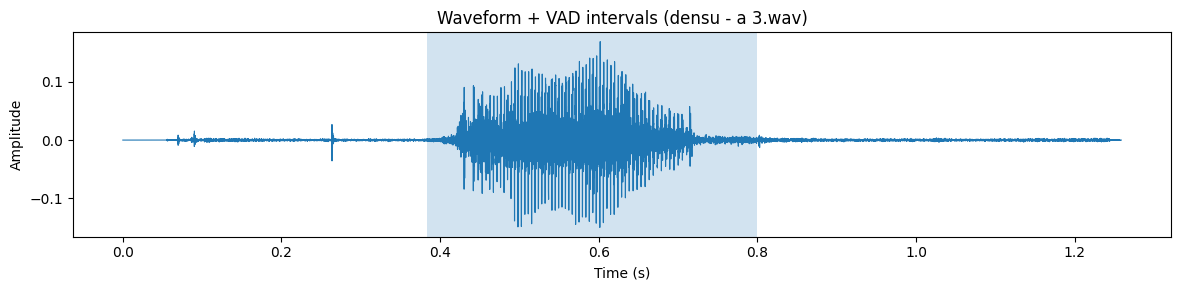

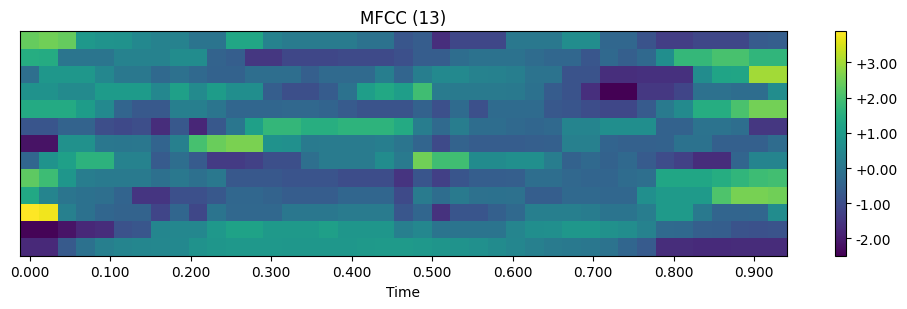

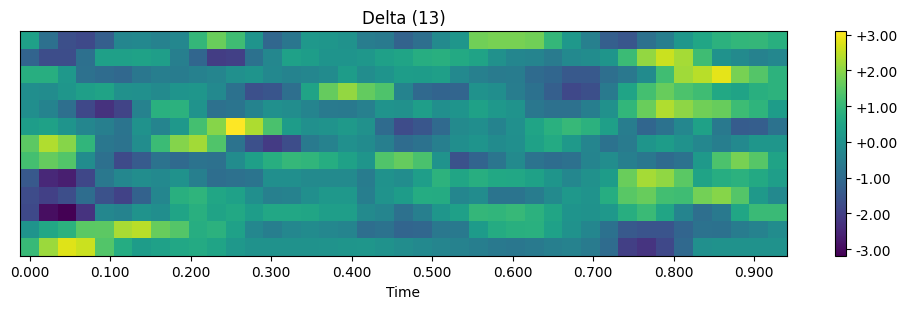

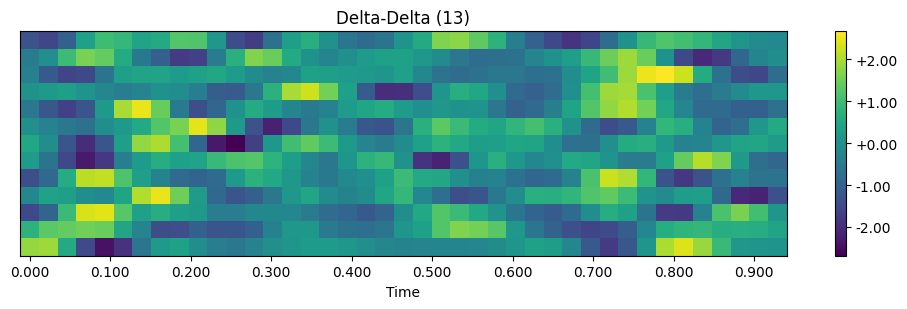

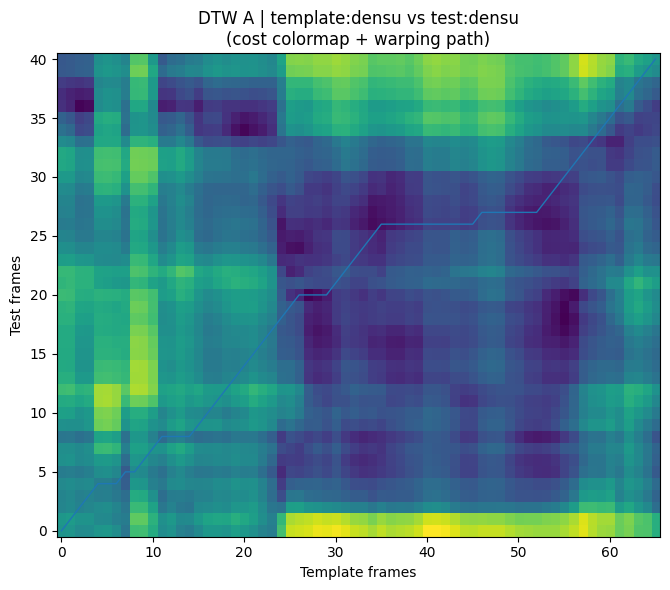

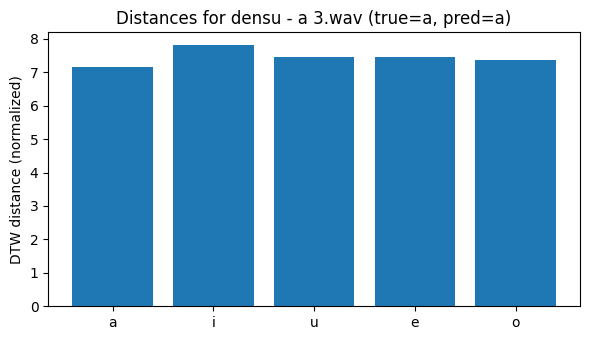


=== STARTING EVALUATION ===

=== EVALUATION WITH TEMPLATES FROM WIGA ===

Total test files (templates_us): 25
Total test files (templates_other): 25

[CLOSED SCENARIO] (all templates vs test from templates_us)

--- DETAILED CLOSED SCENARIO RESULTS ---

  Test: densu - a 3.wav
    Person: densu
    Actual: a | Predicted: a | CORRECT
    Best Distance: 7.1509
    All distances:
      a: 7.1509 <- CHOSEN (CORRECT)
      o: 7.3719
      u: 7.4476
      e: 7.4632
      i: 7.8036

  Test: densu - i 3.wav
    Person: densu
    Actual: i | Predicted: i | CORRECT
    Best Distance: 6.9797
    All distances:
      i: 6.9797 <- CHOSEN (CORRECT)
      e: 7.3866
      u: 7.4612
      o: 7.4941
      a: 7.6235

  Test: densu - u 3.wav
    Person: densu
    Actual: u | Predicted: o | WRONG
    Best Distance: 7.1108
    All distances:
      o: 7.1108 <- CHOSEN
      u: 7.1652 (CORRECT)
      i: 7.4717
      a: 7.4733
      e: 7.5100

  Test: densu - e 3.wav
    Person: densu
    Actual: e | Predicted

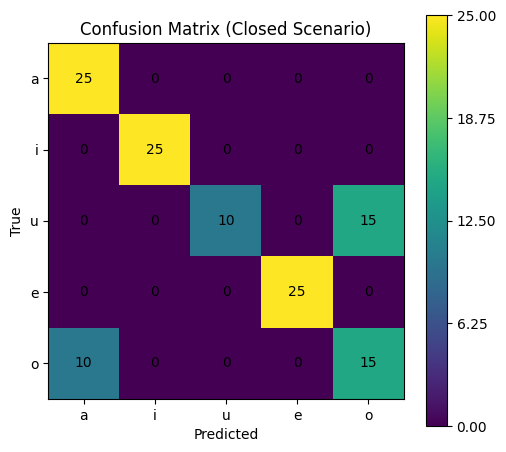


Hasil disimpan ke results/results.json


In [21]:
import os
import json
from typing import List, Tuple

from VowelDTW.VowelRecognitionDTW import VowelRecognitionDTW
from VowelDTW.VowelDTWVisualizer import VowelDTWVisualizer

RESULTS_DIR = "results"
IMAGES_DIR = os.path.join(RESULTS_DIR, "images")
os.makedirs(IMAGES_DIR, exist_ok=True)

def scan_person_folder(folder: str, vowels: List[str]):
    result = {}
    if not os.path.exists(folder):
        print(f"Folder tidak ditemukan: {folder}")
        return result

    for filename in os.listdir(folder):
        if not (filename.endswith(".wav") or filename.endswith(".m4a")):
            continue
        parts = filename.replace('.wav', '').replace('.m4a', '').split(' - ')
        if len(parts) < 2:
            continue
        vowel_num = parts[1].strip().split()
        if len(vowel_num) < 2:
            continue

        vowel_part = vowel_num[0].lower()
        try:
            file_num = int(vowel_num[1])
        except ValueError:
            print(f"Warning: Could not parse number from {filename}")
            continue

        if vowel_part in vowels:
            result.setdefault(vowel_part, []).append((os.path.join(folder, filename), file_num))
    return result


if __name__ == "__main__":
    persons = ['densu', 'hira', 'naufal', 'wiga', 'zya']
    vowels = ['a', 'i', 'u', 'e', 'o']
    base_path = ""  

    recognizer = VowelRecognitionDTW(sample_rate=16000, use_vad=True, normalize=True)
    viz = VowelDTWVisualizer(recognizer)

    # Scan templates_us 
    print("=== SCANNING FILES (templates_us) ===")
    all_files = {}
    for person in persons:
        person_folder = os.path.join(f"{base_path}templates_us", person)
        all_files[person] = scan_person_folder(person_folder, vowels)

    # Load templates & build test set (US) 
    print("\n=== LOADING TEMPLATES (using files with smaller numbers) ===")
    test_data_us: List[Tuple[str, str, str]] = []
    for person in persons:
        for vowel in vowels:
            files = all_files.get(person, {}).get(vowel, [])
            files.sort(key=lambda x: x[1])
            if len(files) == 0:
                continue

            # semua kecuali terakhir -> template, terakhir -> test
            template_files = files[:-1] if len(files) > 1 else []
            test_file = files[-1]

            for file_path, _ in template_files:
                try:
                    recognizer.add_template(vowel, person, file_path)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

            test_data_us.append((test_file[0], vowel, person))

    print(f"\n=== TEST DATA (templates_us - using files with largest numbers) ===")
    print(f"Total: {len(test_data_us)} test files")

    # Scan templates_other 
    print("\n=== SCANNING FILES (templates_other) ===")
    all_files_other = {}
    folder_other = f"{base_path}templates_other"
    if os.path.exists(folder_other):
        for person in os.listdir(folder_other):
            person_folder = os.path.join(folder_other, person)
            if not os.path.isdir(person_folder):
                continue
            all_files_other[person] = scan_person_folder(person_folder, vowels)
    else:
        print(f"Folder tidak ditemukan: {folder_other}")

    # Build test_data_other dari file terakhir tiap vowel
    test_data_other: List[Tuple[str, str, str]] = []
    print("\n=== TEST DATA (templates_other - using files with largest numbers) ===")
    for person in all_files_other:
        for vowel in vowels:
            files = all_files_other[person].get(vowel, [])
            files.sort(key=lambda x: x[1])
            if len(files) == 0:
                continue
            test_file = files[-1]
            test_data_other.append((test_file[0], vowel, person))
    print(f"Total: {len(test_data_other)} test files")

    # Contoh Visualisasi untuk satu sampel 
    if len(test_data_us) > 0:
        sample_path, sample_true, sample_person = test_data_us[0]
        sample_base = os.path.splitext(os.path.basename(sample_path))[0]

        # Waveform + VAD & MFCC-39
        viz.plot_waveform_with_vad(
            sample_path,
            top_db=20,
            save_path=os.path.join(IMAGES_DIR, f"{sample_base}_waveform_vad.png")
        )
        viz.plot_mfcc39(
            sample_path,
            save_prefix=os.path.join(IMAGES_DIR, f"{sample_base}_mfcc39")
        )

        # DTW alignment terhadap salah satu template dari vokal yang sama
        if sample_true in recognizer.templates and len(recognizer.templates[sample_true]) > 0:
            first_pid, templ_list = next(iter(recognizer.templates[sample_true].items()))
            if len(templ_list) > 0:
                template_feats = templ_list[0]
                test_feats = recognizer.extract_mfcc_39(sample_path)
                viz.plot_dtw_alignment(
                    template_feats, test_feats,
                    title=f"DTW {sample_true.upper()} | template:{first_pid} vs test:{sample_person}",
                    save_path=os.path.join(IMAGES_DIR, f"{sample_base}_dtw_alignment.png")
                )

        # Bar distances untuk sampel ini
        pred, dist, _, final_d = recognizer.recognize(sample_path, use_averaging=True)
        viz.plot_vowel_distances_bar(
            final_d,
            title=f"Distances for {os.path.basename(sample_path)} (true={sample_true}, pred={pred})",
            save_path=os.path.join(IMAGES_DIR, f"{sample_base}_vowel_distances.png")
        )

    # Evaluasi lengkap 
    print("\n=== STARTING EVALUATION ===")
    results = recognizer.evaluate_all_scenarios(test_data_us, test_data_other)

    # Confusion matrix (closed) sebagai heatmap
    all_closed_results = []
    for person_results in results.values():
        if isinstance(person_results, dict) and 'closed_results' in person_results:
            all_closed_results.extend(person_results['closed_results'])
    if len(all_closed_results) > 0:
        viz.plot_confusion_heatmap(
            all_closed_results,
            vowels=recognizer.vowels,
            title="Confusion Matrix (Closed Scenario)",
            save_path=os.path.join(IMAGES_DIR, "confusion_matrix_closed.png")
        )

    # Simpan ringkasan angka ke JSON (ke folder results/)
    os.makedirs(RESULTS_DIR, exist_ok=True)
    json_path = os.path.join(RESULTS_DIR, 'results.json')
    with open(json_path, 'w') as f:
        json_results = {}
        for k, v in results.items():
            if k != 'overall':
                json_results[k] = {
                    'closed_accuracy': v['closed_accuracy'],
                    'open_accuracy': v['open_accuracy'],
                    'average_accuracy': v['average_accuracy']
                }
            else:
                json_results[k] = v
        json.dump(json_results, f, indent=2)
    print(f"\nHasil disimpan ke {json_path}")
